In [1]:


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU


In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from PIL import Image
import os
import random

In [3]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
# import cv2

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

In [4]:
path_test = "flowers/"

In [5]:
CATEGORIES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
IMG_SIZE =200


In [6]:
#Image Augmentation
import cv2
training = []
def createTrainingData():
    for category in CATEGORIES:
        path = os.path.join(path_test, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])

createTrainingData()

In [7]:

random.shuffle(training)

In [8]:

X =[]
y =[]
for features, label in training:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [9]:
X = X.astype('float32')
X /= 255
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 5)
print(Y[100])
print(Y.shape)
print(X.shape)

[0. 1. 0. 0. 0.]
(4317, 5)
(4317, 200, 200, 3)


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)
n = int(len(X_test)/2)
x_valid, y_valid = X_test[:n], y_test[:n]
x_test, y_test = X_test[n:], y_test[n:]

Label:  sunflower


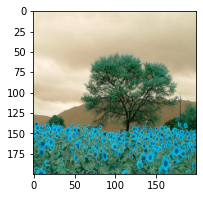

In [11]:
print('Label: ', CATEGORIES[np.argmax(y_train[13])])
plt.figure(figsize=(3,3))
plt.imshow((X_train[13]));

In [12]:
def model():
    #model creation
    model = Sequential()

    #Adding layers
    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    #CompilIng the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()
#Saving the model
checkpointer = ModelCheckpoint(filepath='cnn_model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 198, 198, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 97, 97, 128)       0         
                                                        

In [15]:
history = model.fit(X_train, y_train, 
                    epochs=5, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.04399, saving model to cnn_model.hdf5
108/108 - 196s - loss: 1.1280 - accuracy: 0.5224 - val_loss: 1.0440 - val_accuracy: 0.5880 - lr: 0.0010 - 196s/epoch - 2s/step
Epoch 2/5

Epoch 2: val_loss improved from 1.04399 to 0.99317, saving model to cnn_model.hdf5
108/108 - 196s - loss: 0.9730 - accuracy: 0.6134 - val_loss: 0.9932 - val_accuracy: 0.5972 - lr: 0.0010 - 196s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 0.99317 to 0.87793, saving model to cnn_model.hdf5
108/108 - 196s - loss: 0.8877 - accuracy: 0.6525 - val_loss: 0.8779 - val_accuracy: 0.7315 - lr: 0.0010 - 196s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss improved from 0.87793 to 0.83308, saving model to cnn_model.hdf5
108/108 - 196s - loss: 0.8426 - accuracy: 0.6742 - val_loss: 0.8331 - val_accuracy: 0.7292 - lr: 0.0010 - 196s/epoch - 2s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.83308 to 0.78277, saving model to cnn_model.hdf5
108/108 - 195s - loss: 0.7

In [16]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),
                                 steps_per_epoch = len(X_train)//64, epochs=5, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

<ipython-input-16-66136e9f2b38>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),


Epoch 1/5

Epoch 1: val_loss improved from 0.78277 to 0.73422, saving model to cnn_model.hdf5
53/53 - 194s - loss: 0.7727 - accuracy: 0.7132 - val_loss: 0.7342 - val_accuracy: 0.7384 - lr: 0.0010 - 194s/epoch - 4s/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.73422
53/53 - 196s - loss: 0.7666 - accuracy: 0.7043 - val_loss: 0.7356 - val_accuracy: 0.7569 - lr: 0.0010 - 196s/epoch - 4s/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.73422
53/53 - 201s - loss: 0.7396 - accuracy: 0.7226 - val_loss: 0.7741 - val_accuracy: 0.7199 - lr: 0.0010 - 201s/epoch - 4s/step
Epoch 4/5

Epoch 4: val_loss improved from 0.73422 to 0.69927, saving model to cnn_model.hdf5
53/53 - 201s - loss: 0.7458 - accuracy: 0.7203 - val_loss: 0.6993 - val_accuracy: 0.7523 - lr: 0.0010 - 201s/epoch - 4s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.69927 to 0.69728, saving model to cnn_model.hdf5
53/53 - 203s - loss: 0.7131 - accuracy: 0.7297 - val_loss: 0.6973 - val_accuracy: 0.7708 - lr: 0.0010 

In [17]:
model.load_weights('cnn_model.hdf5')

In [18]:
#Test the model
score1 = model.evaluate(x_test, y_test)
score1

14/14 [==============================] - 5s 364ms/step - loss: 0.6983 - accuracy: 0.7639


[0.6983276009559631, 0.7638888955116272]

In [19]:
score2 = model.evaluate(X_train, y_train)
score2

108/108 [==============================] - 40s 369ms/step - loss: 0.6828 - accuracy: 0.7767


[0.6827535033226013, 0.776715874671936]

In [20]:
score3 = model.evaluate(x_valid, y_valid)
score3


14/14 [==============================] - 5s 353ms/step - loss: 0.6973 - accuracy: 0.7708


[0.6972822546958923, 0.7708333134651184]

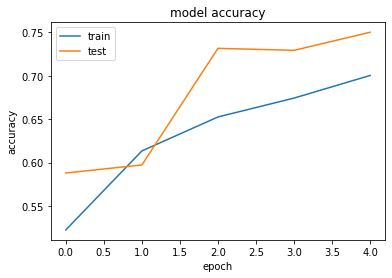

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

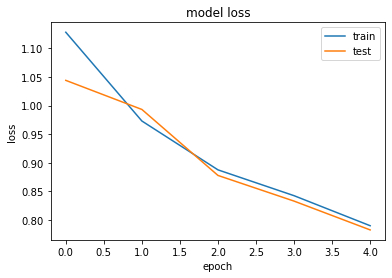

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
model.save('model.h5')
model1 = load_model('model.h5')
y_test_predict = model1.predict(x_test)

y_test_predict = np.argmax(y_test_predict,axis=1)


14/14 [==============================] - 6s 363ms/step


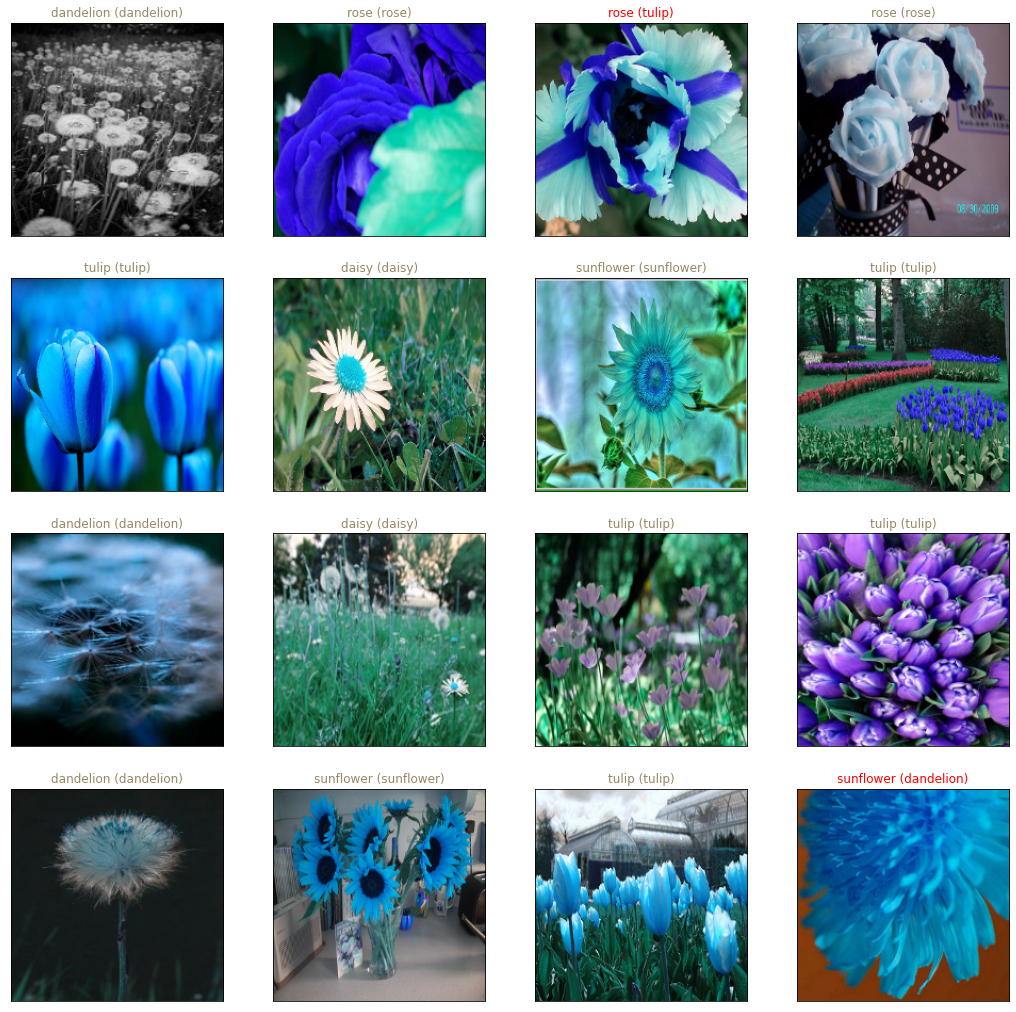

In [28]:

fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(CATEGORIES[pred_idx], CATEGORIES[true_idx]),
                 color=("#998765" if pred_idx == true_idx else "red"))